In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import logging
import requests
import datetime as dt
import pylab

import scipy.stats as stats
from matplotlib import pyplot

import numpy as np

import warnings
warnings.filterwarnings('ignore')

logging.getLogger().setLevel(logging.INFO)


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os, sys

home = os.environ["HOME"]
sys.path.append(f"{home}/Desktop/project-ursa/lib")

import imp

import monte_carlo
imp.reload(monte_carlo)

import data_utils
imp.reload(data_utils)

# import data_analysis
# imp.reload(data_analysis)

import mining_constants
imp.reload(mining_constants)

import machine_npv
imp.reload(machine_npv)

<module 'machine_npv' from '/Users/merkle-employee/Desktop/project-ursa/lib/machine_npv.py'>

In [2]:
du = data_utils.DataUtility("cc_key")

##
du._raw_network_price_df = pd.read_csv("../../data/raw_network_price.csv").drop("Unnamed: 0", axis="columns")
du._raw_network_price_df.time = pd.to_datetime(du._raw_network_price_df.time)
du._df_feature() 
du._aggregate_weekly_df() 

daily_df  = du._daily_network_price_df
weekly_df = du._weekly_network_price_df

## 
sp = monte_carlo.GBMPriceLinearHashRate()
sp.fit(weekly_df, sample_rate=mining_constants.SAMPLE_RATE_WEEKLY)

## 
k = 130

start_time = weekly_df.reset_index().loc[k, "time"]
hash_rate  = weekly_df.reset_index().loc[k, "hashrate"]
hash_index = weekly_df.reset_index().loc[k, "hash_index"]
btc_close  = weekly_df.reset_index().loc[k, "close"]

print({"week": start_time, "hashrate": hash_rate, "hash-index": hash_index, "btc-close": btc_close})


{'week': datetime.date(2020, 5, 1), 'hashrate': 112590961.54919858, 'hash-index': 0.1302892607098581, 'btc-close': 8149.662857142857}


In [4]:
## -------------------------------------------------------
machine_params   = mining_constants.machine_params()
ky = mining_constants.MACHINE_M20

## No Loss USD analysis.
params = {
    "asic_energy_consumption" : machine_params[ky]["energy_consumption"],
    "asic_hash_rate"          : machine_params[ky]["hash_rate"],
    "electricity_cost"        : 0.05,
    "machine_duration"        : 1.0,
    "sample_rate"             : mining_constants.SAMPLE_RATE_WEEKLY,
    "mc_size"                 : 5000,
    "interest_rate"           : 0.05,
    "asic_number"             : 1,
    "asic_efficiency"         : 1.0,
    "pool_fee"                : 0.005,
    "BTC_DENOMINATED"         : True
}

# params, start_time, btc_close, hash_rate, ccr)
sp = monte_carlo.GBMPriceLinearHashRate()
sp.fit(weekly_df, sample_rate=mining_constants.SAMPLE_RATE_WEEKLY)

m_usd_bsm = machine_npv.MachineNPV_BTC_Bin(sp, params)
m_npv     = m_usd_bsm.price(start_time, btc_close, hash_rate, 100)


In [ ]:
# m_npv
# 
# m_usd_bsm._option_df
# 
# # print(m_npv)
# ccr = 0.97
# m   = machine_npv.MCDefaultRate(sp, params)
# pr_default = m.default_rate_usd(
#         start_time, 
#         btc_close, 
#         hash_rate, 
#         mu_annual = params["interest_rate"], 
#         loan_value = m_npv * (1 / ccr)
#     )
# 
# pr_default
# 
# # print(m_npv)
# ccr = 1.03
# m   = machine_npv.MCDefaultRate(sp, params)
# pr_default = m.default_rate_usd(
#         start_time, 
#         btc_close, 
#         hash_rate, 
#         mu_annual = params["interest_rate"], 
#         loan_value = m_npv * (1 / ccr)
#     )
# 
# pr_default

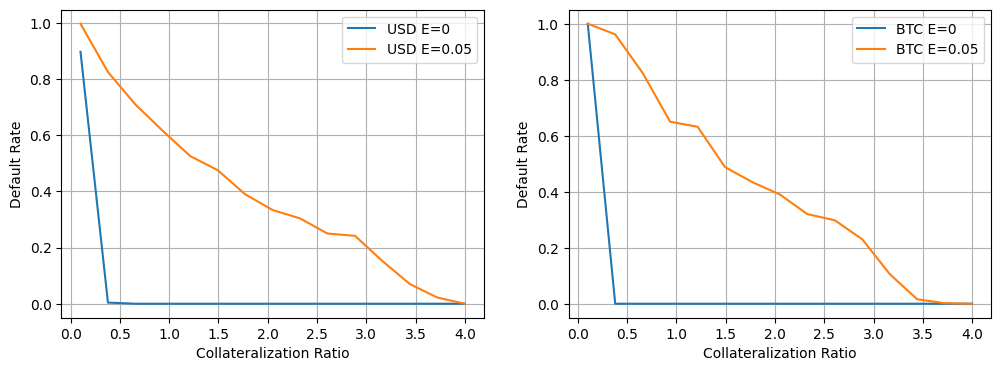

In [10]:
df_usd = pd.read_csv("../../data/usd_ccr_vs_default_130.csv")
df_btc = pd.read_csv("../../data/btc_ccr_vs_default_130.csv")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(df_usd.ccr, df_usd.no_loss_default, label="USD E=0")
plt.plot(df_usd.ccr, df_usd.loss_default, label="USD E=0.05")
plt.xlabel("Collateralization Ratio")
plt.ylabel("Default Rate")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df_btc.ccr, df_btc.no_loss_default, label="BTC E=0")
plt.plot(df_btc.ccr, df_btc.loss_default, label="BTC E=0.05")
plt.xlabel("Collateralization Ratio")
plt.ylabel("Default Rate")
plt.legend()
plt.grid()
